## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
len(df[(df['converted']==True)])/df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df1=df.copy()
df2=df1.query('group == "treatment" and landing_page =="new_page" or group == "control" and landing_page =="old_page"')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
repeated_user=df2[df2['user_id'].duplicated()==True]


In [12]:
sum(df2['user_id'].duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [13]:
print(repeated_user)

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates(['user_id'], keep='first')

In [15]:
#check if the duplicated row is removed
sum(df2['user_id'].duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
len(df2[df2['converted']==True])/df2.shape[0]

0.11959708724499628

In [17]:
#number of people in control group
len(df2[df2['group']=='control']) 

145274

In [18]:
#number of people in control group and converted
len(df2[(df2['converted']==True) & (df2['group']=='control')])

17489

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
actual_control=len(df2[(df2['converted']==True) & (df2['group']=='control')])/len(df2[df2['group']=='control']) 
actual_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
actual_treatment=len(df2[(df2['converted']==True) & (df2['group']=='treatment')])/len(df2[df2['group']=='treatment']) 
actual_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
len(df2[df2['landing_page']=='new_page'])/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

###### It is hard to conclude that the new page leads more conversions. It is because the probability of conversion for control group (p=~0.120) is almost the same value as probability of conversion for treatment group(p=~0.119). This quick probability overview requires me to do some statistical analysis to be able to answer the question with confidence. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null Hypothesis = The old page performs same or better than the new page (𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 <= 0) 

#### Hypothesis1= The new page performs better than the old page (𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 >0) 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
𝑝𝑛𝑒𝑤 = len(df2[df2['converted']==True])/df2.shape[0]
𝑝𝑛𝑒𝑤 

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
𝑝𝑜𝑙𝑑= len(df2[df2['converted']==True])/df2.shape[0]
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
𝑛𝑛𝑒𝑤 =len(df2[df2['group']=='treatment'])
𝑛𝑛𝑒𝑤 

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
𝑛𝑜𝑙𝑑=len(df2[df2['group']=='control'])
𝑛𝑜𝑙𝑑 

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted=np.random.choice([0,1], size=𝑛𝑛𝑒𝑤, p=[(1-𝑝𝑛𝑒𝑤), 𝑝𝑛𝑒𝑤])


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted=np.random.choice([0,1], size=𝑛𝑜𝑙𝑑, p=[(1-𝑝𝑜𝑙𝑑), 𝑝𝑜𝑙𝑑])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
x=new_page_converted.mean() - old_page_converted.mean()
x

-0.0023973022979572739

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

(array([    8.,    54.,   398.,  1257.,  2476.,  2947.,  1936.,   759.,
          150.,    15.]),
 array([ -7.13270150e-03,  -6.22969459e-03,  -5.32668768e-03,
         -4.42368077e-03,  -3.52067386e-03,  -2.61766695e-03,
         -1.71466004e-03,  -8.11653131e-04,   9.13537789e-05,
          9.94360689e-04,   1.89736760e-03]),
 <a list of 10 Patch objects>)

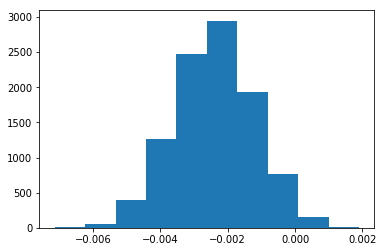

In [30]:
p_diffs=[]
for _ in range (10000):
    boot_n_mean=np.random.choice(new_page_converted, nnew, replace=True).mean()
    boot_o_mean=np.random.choice(old_page_converted, nold, replace=True).mean()
    p_diffs.append(boot_n_mean-boot_o_mean)
    
plt.hist(p_diffs)    
    

In [31]:
np.percentile(p_diffs,2.5), np.percentile(p_diffs,97.5)

(-0.0047446059790185518, -9.1690514105749493e-05)

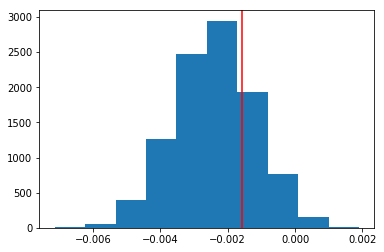

In [32]:
actual=actual_treatment - actual_control
plt.hist(p_diffs)
plt.axvline(x=actual, color='red')

In [34]:
#Since the arrays are composed of 0 and 1, I also wanted to use binomial bootstrapping and see how the hypothesis testing would change as a result 
new_page_simulation=np.random.binomial(𝑛𝑛𝑒𝑤, 𝑝𝑛𝑒𝑤, size=10000)/𝑛𝑛𝑒𝑤
old_page_simulation=np.random.binomial(𝑛𝑜𝑙𝑑, 𝑝𝑜𝑙𝑑, size=10000)/𝑛𝑜𝑙𝑑
p_diff=new_page_simulation - old_page_simulation
p_diff


array([ 0.00139499, -0.00160587,  0.00031437, ..., -0.00055935,
        0.00144329, -0.00069057])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

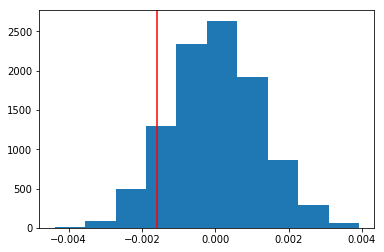

In [35]:
#based on using binomial function to bootstrap the mean difference 
actual=actual_treatment - actual_control
plt.hist(p_diff)
plt.axvline(x=actual, color='red')

In [36]:
np.percentile(p_diff,2.5), np.percentile(p_diff,97.5)

(-0.0023631387792231932, 0.0024139631632487551)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [41]:
p_diff = np.array(p_diff) #based on binomial bootstrapping
(p_diff > actual).mean()

0.90139999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

###### Random Choice Bootstrapping Results: Confidence Interval shows that the p_diffs range from -0.0048 to -2.2557. So the mean difference is smaller than zero. In other words, we failed to reject null hypothesis which is old page performs same or better than new page. Binomial Bootstrapping Results: Confidence Interval shows that the p_diff range from -0.002 to 0.002 including value of zero. In other words, we fail to reject null hypothesis. We failed to show if there is a difference between the new and the old page. 


** **

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [43]:
import statsmodels.api as sm

convert_old = np.random.choice(old_page_converted, nold, replace=True).mean()
convert_new = np.random.choice(new_page_converted, nnew, replace=True).mean()
n_old = nold
n_new = nnew

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [47]:
from scipy.stats import norm

z_score, p_value = sm.stats.proportions_ztest( [ convert_new, convert_old ], [ n_new, n_old ], alternative='larger' )

print('Z-score critical value (95% confidence) to' + ' reject the null: ' + str(norm.ppf(1-(0.05/2))))
    
print('z_score = ' + str(z_score))
print('p_value = ' + str(p_value))

Z-score critical value (95% confidence) to reject the null: 1.95996398454
z_score = -0.00473650866012
p_value = 0.501889586501


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

###### Z-score of -0.0047 doesn't exceed the critical value of 1.95 and  p_value of 0.501 is larger than the alpha value of 0.05. Therefore, we fail to reject the null hypothesis. This finding reaches is the same conclusion that we reached with bootstrapping technique summarized in parts j and k. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression to predict two possible outcomes like conversion or no conversion**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [52]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [48]:
df2['intercept'] = 1

In [49]:
df2= df2.join(pd.get_dummies(df2['landing_page']))

In [50]:
df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']

In [51]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [53]:
#I am using logit regression model.
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [54]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:48:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

###### Part II - p-value was ~0.9  and the p-value in Part III associated with ab_page is 0.190. In Part II, I was trying to reject null hypothesis to prove that alternative hypothesis is correct. However, in the Part II, I failed to reject null, in other words, it is still valid that old page performs same or better than new page. However, in Part III, I am trying to understand if the ab_page is ( 1=the new page) is significant in predicting the conversion behavior that is in my data.   And, p-value should have come back less than 0.05 to reject the null, which is variable is not significant in the model to explain the data and to show the significance of the new page ( variable). But, it didn't so it means need more variables in my model to be able to predict the conversion behavior. 


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

###### So single variable model didn't predict the data and the conversion behavior within the data. So, we can throw in more variables to see if we can create a better fit with the model and the data.  The more variables I throw in the model,  I might get correlated errors, introduce more outliers to the model, or some variables may not have linear relationship with the outcome value. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [55]:
country= pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [57]:
df3 = df2.merge(country, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [58]:
### Create dummies
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

In [59]:
logit_new = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
results_new = logit_new.fit()
results_new.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 08 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        21:11:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

###### None of the coefficients ( ab_page, US, UK) are significant to predicting the conversion behavior. We can see this both from coefficient values of the variables and their associating p-values by being >0.05. The proposed model is not a good fit for the existing data. And model requires modifications to predict the data. 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0